<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br>Assignment 2 [GROUP PROJECT]</h1>

---
<br>

#### **Your Unis** : sc4040, ajh2259, fsa2139
#### **Your Full names** : Shayan Chowdhury, Andrew James Hamilton, Faaz Saad Arshad
#### **Your AI Model Share Usernames**: sc4040, ajh2259, fsarshad
#### **Link to your Public Github repository** : https://github.com/fsarshad/Covid19XRaysHw2/
#### **Team member Contribution Percentages** : 33.33% each

In [ ]:
import os
import sys
import time
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import load_model
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

Number of images for each category: [3616, 10192, 1345]


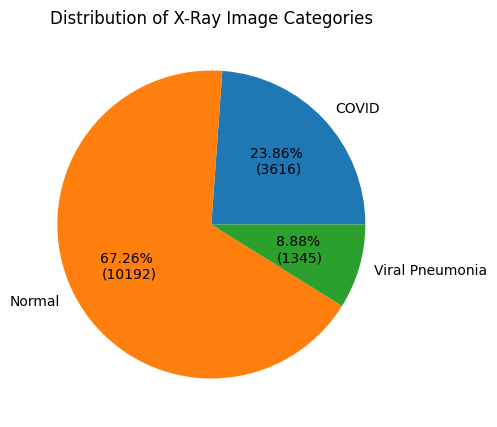

In [ ]:
# Extracting all filenames iteratively
base_path = '../COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

value_counts = [len(f) for f in fnames]
print('Number of images for each category:', value_counts)

# Plot the distribution of the images as a pie chart
plt.figure(figsize=(5,5))
plt.title('Distribution of X-Ray Image Categories')
labels = ['COVID', 'Normal', 'Viral Pneumonia']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(value_counts, labels=labels, autopct=make_autopct(value_counts))
plt.show()
# print(fnames[0:2]) #examples of file names

In [ ]:
# Reduce number of images to first 1345 for each category to balance the dataset
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.

# Preprocessor function will match up with model's expected input shape
image_size = (256, 256) # All images will be resized to 256x256
def preprocessor(img_path):
    img = Image.open(img_path).convert("RGB").resize(image_size) # import image, make sure it's RGB and resize to height and width you want.
    img = (np.float32(img)-1.)/(255-1.) # min max transformation
    img=img.reshape(image_size + (3,)) # Create final shape as array with correct dimensions for Keras
    return img

# Import image files iteratively and preprocess them into array of correctly structured data
# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function
# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor, image_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

# Normalize the image pixel values to 0-1 range
X = (X - X.min())/(X.max()-X.min())

# Print out some key details about the data
print('Size of dataset:', len(X), sep='\t') # same number of elements as filenames
print('Shape of dataset:', X.shape, sep='\t') # dimensions now 256x256x3 for all images
print('Min value of every image:', X.min(), sep='\t') # min value of every image is zero
print('Max value of every image:', X.max(), sep='\t') # # max value of every image is one

Size of dataset:	4032
Shape of dataset:	(4032, 256, 256, 3)
Min value of every image:	0.0
Max value of every image:	1.0


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each X-ray category
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid + normal + pneumonia

#check length, same as X above
print('Size of y:', len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas
import pandas as pd
y = pd.get_dummies(y_labels)

print('One hot encoding representation of y (random subset):')
print(y.sample(5).to_numpy())

Size of y: 4032
One hot encoding representation of y (random subset):
[[1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]


# **STEP 3: Visualizations <span style="color:yellow;">(5pts)</span>**

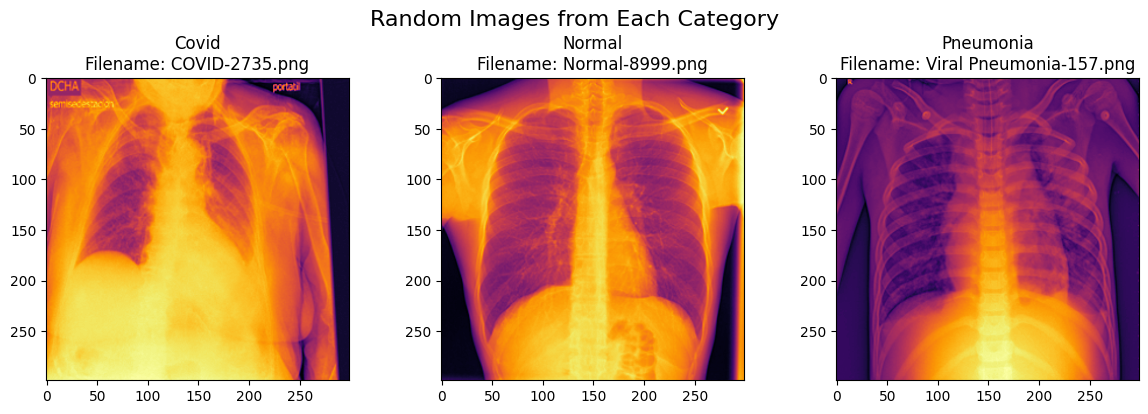

In [ ]:
# We know fnames is a list of lists, with each list containing the image filepaths in each category
covid_images = fnames[0]
normal_images = fnames[1]
pneumonia_images = fnames[2]

# Use random.choice to select random image from each category
rand_covid_image = random.choice(covid_images)
rand_normal_image = random.choice(normal_images)
rand_pneumonia_image = random.choice(pneumonia_images)

# Make a 3x1 subplot to display random images from each category
plt.figure(figsize=(12, 4))
plt.suptitle('Random Images from Each Category', fontsize=16)

plt.subplot(131)
plt.imshow(plt.imread(rand_covid_image), cmap='inferno')
plt.title('Covid' + '\nFilename: ' + rand_covid_image.split('/')[-1])

plt.subplot(132)
plt.imshow(plt.imread(rand_normal_image), cmap='inferno')
plt.title('Normal' + '\nFilename: ' + rand_normal_image.split('/')[-1])

plt.subplot(133)
plt.imshow(plt.imread(rand_pneumonia_image), cmap='inferno')
plt.title('Pneumonia' + '\nFilename: ' + rand_pneumonia_image.split('/')[-1])

plt.tight_layout()
plt.show()

# **STEP 4: Analyzing and Augmenting Dataset <span style="color:yellow;">(10pts)</span>**


**What are the data analysis steps you performed? What did you notice? What are you conclusions?**

...


In [ ]:
# Define the augmentation parameters (for modularization)
def get_image_augmentation_pipeline():
    return tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.075), # Rotate up to 10% * 2pi
    tf.keras.layers.RandomZoom(0.2), # Zoom up to 20%
    tf.keras.layers.RandomContrast(0.2), # Adjust contrast up to 20%
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Translate up to 10% in x and y
])

# Instantiate the augmentation pipeline
image_augmentations = get_image_augmentation_pipeline()

2024-04-02 21:26:38.934087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-02 21:26:38.996367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-02 21:26:39.072884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-02 21:26:39.151129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-02 21:26:39.223519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-02 21:26:39.286373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

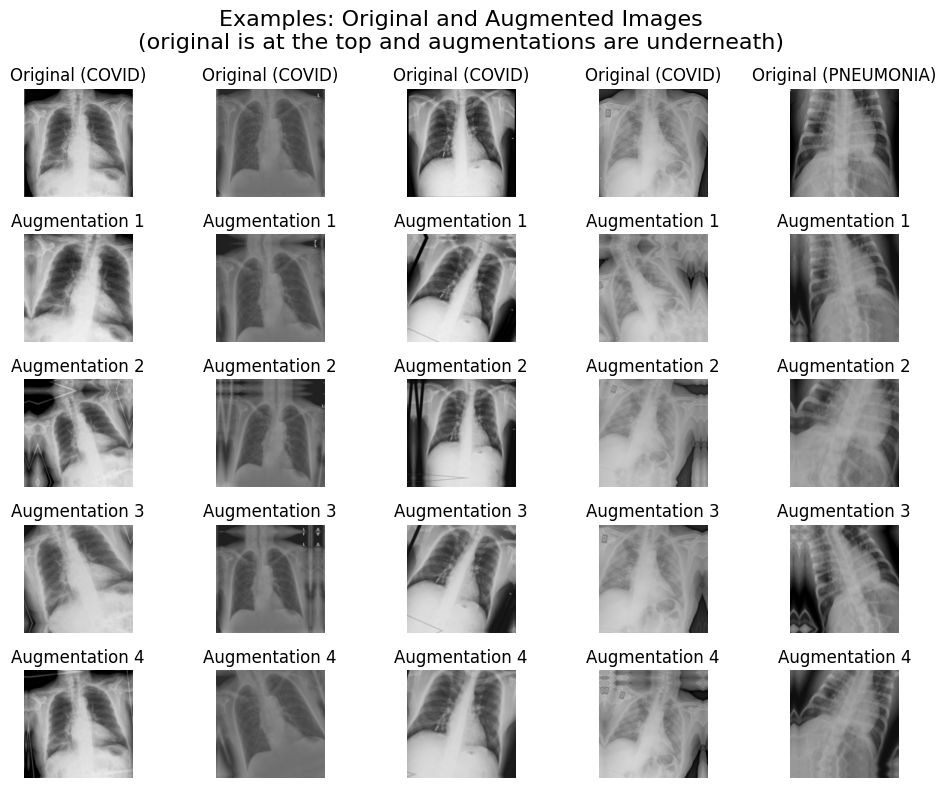

In [ ]:
# Apply the augmentation to some example images
NUM_IMAGES = 5
NUM_AUGS = 4
idxs = random.sample(range(len(X)), NUM_IMAGES)
images, labels = X[idxs], y.iloc[idxs]
fig, ax = plt.subplots(nrows=NUM_AUGS+1, ncols=NUM_IMAGES, figsize=(10, 8))
fig.suptitle('Examples: Original and Augmented Images\n(original is at the top and augmentations are underneath)', fontsize=16)
for i in range(NUM_IMAGES):
    ax[0, i].imshow(images[i])
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Original ({y.columns[labels.to_numpy()[i].argmax()]})')
    for j in range(NUM_AUGS):
        images_aug = image_augmentations(images).numpy()
        ax[j+1, i].imshow(images_aug[i])
        ax[j+1, i].axis('off')
        ax[j+1, i].set_title(f'Augmentation {j+1}')
plt.tight_layout()

In [ ]:
# # Create a dataset of augmented images (increase dataset size)
# from tqdm.auto import tqdm

# BATCH_SIZE = 32 # Number of images to process at once
# NUM_AUGS = 2 # Number of augmentations to apply to each image (i.e. 3x increase in dataset size)

# # Loop through the dataset in batches and apply augmentations
# # Batches are much faster than individual images because of GPU parallelization!
# X_aug, y_aug = [], []
# batch_idx = list(range(0, len(X), BATCH_SIZE)) + [len(X)] # Since range is exclusive, add the last index
# for i in tqdm(range(len(batch_idx) - 1)):
#     start_idx, end_idx = batch_idx[i], batch_idx[i+1]
#     X_batch, y_batch = X[start_idx:end_idx], y[start_idx:end_idx]
#     # First image is the original
#     X_aug.append(X_batch)
#     y_aug.append(y_batch)
#     # ...and the rest are augmentations
#     for _ in range(NUM_AUGS):
#         X_aug.append(image_augmentations(X_batch).numpy())
#         y_aug.append(y_batch)

# # Convert the augmented data to numpy arrays
# X_aug = np.array(X_aug).reshape(-1, 256, 256, 3)
# y_aug = np.array(y_aug).reshape(-1, 3)

# print('Original dataset shape:', X.shape)
# print('Augmented dataset shape:', X_aug.shape)

In [ ]:
# # If everything looks good, overwrite the original data with the augmented data
# X, y = X_aug, y_aug

**What specific preprocessing and augmentation strategies did you apply to your dataset, and why? How would these strategies improve your model's training and generalization?**

To augment our dataset, we are artificially introducing sample diversity by applying random, yet realistic, transformations to the training images. The data augmentation techniques we apply to the training dataset, include random horizontal flipping, rotation, zooming, contrast adjustment, and translation.

By exposing the model to augmented examples during training, it learns to recognize objects/patterns regardless of their orientation, size, position, or lighting conditions within the input images. This enhanced invariance to transformations improves the model's ability to generalize to unseen data—preventing overfitting and encouraging learning more general features. Augmentations like adjustment to contrast make the model robust to noise/variations in real-world data. These preprocessing and augmentation techniques can significantly boost the model's performance, generalization capabilities, and robustness.

One
# ^ NOTE: Akarsh mentioned in class to augment the test/validation dataset as well  


# **STEP 5: Splitting Dataset**

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.32, random_state = 1987)

print('X_train shape:', X_train.shape, sep='\t')
print('y_train shape:', y_train.shape, sep='\t')
print('X_test shape:', X_test.shape, sep='\t')
print('y_test shape:', y_test.shape, sep='\t')

# Check the distribution of labels in the train and test sets
from collections import Counter
print('Value counts in y_train:', Counter(y_train.to_numpy().argmax(axis=1)))
print('Value counts in y_test:', Counter(y_test.to_numpy().argmax(axis=1)))

X_train shape:	(2741, 256, 256, 3)
y_train shape:	(2741, 3)
X_test shape:	(1291, 256, 256, 3)
y_test shape:	(1291, 3)
Value counts in y_train: Counter({1: 914, 0: 914, 2: 913})
Value counts in y_test: Counter({2: 431, 0: 430, 1: 430})


In [ ]:
# Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
# Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Save data using binary pickle files (truncated version of original code given)
with open('./data/X_train.pkl', 'wb') as file: pickle.dump(X_train, file)
with open('./data/y_train.pkl', 'wb') as file: pickle.dump(y_train, file)
with open('./data/X_test.pkl', 'wb') as file: pickle.dump(X_test, file)
with open('./data/y_test.pkl', 'wb') as file: pickle.dump(y_test, file)

In [ ]:
# If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Load data using pickle
with open('./data/X_train.pkl', 'rb') as file: X_train = pickle.load(file)
with open('./data/y_train.pkl', 'rb') as file: y_train = pickle.load(file)
with open('./data/X_test.pkl', 'rb') as file: X_test = pickle.load(file)
with open('./data/y_test.pkl', 'rb') as file: y_test = pickle.load(file)

# **STEP 6: Model Training and parameter tuning <span style="color:yellow;"> (45pts)</span>**

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
from aimodelshare.aws import set_credentials

ai.export_preprocessor(preprocessor,"")

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

experiment= ai.Experiment(apiurl)

set_credentials(apiurl=apiurl)

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/site-packages/aimodelshare/preprocessormodules.py:170: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


Your preprocessor is now saved to 'preprocessor.zip'


Modelshare.ai login credentials set successfully.


# **STEP 6(a): Custom CNN based models**

## Custom Model 1
**Note:** this model is intentionally more basic and uses fewer layers to juxtapose the more complex models below

In [ ]:
# First, create a dataset of augmented images to train our models with
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).map(lambda x, y: (image_augmentations(x), y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).map(lambda x, y: (image_augmentations(x), y))
# ^ NOTE: Akarsh mentioned in class to augment the test/validation dataset as well

In [ ]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import Adam

input_shape = X_train[0].shape
model_custom_1 = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model_custom_1.compile(
    optimizer=Adam(learning_rate=0.0001), # Reduced learning rate from 1e-3 to 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('Model summary:')
model_custom_1.summary()

Model summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32,

In [ ]:
# Train the model
# Set hyperparameters
NUM_EPOCHS = 15

model_custom_1_history = model_custom_1.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset,
)

Epoch 1/15


2024-04-02 21:27:24.919670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-04-02 21:27:25.955220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


86/86 [==============================] - 36s 400ms/step - loss: 0.8997 - accuracy: 0.5476 - val_loss: 0.7061 - val_accuracy: 0.6569
Epoch 2/15
86/86 [==============================] - 35s 401ms/step - loss: 0.6836 - accuracy: 0.6757 - val_loss: 0.6380 - val_accuracy: 0.7088
Epoch 3/15
86/86 [==============================] - 34s 397ms/step - loss: 0.6301 - accuracy: 0.6976 - val_loss: 0.6362 - val_accuracy: 0.7149
Epoch 4/15
86/86 [==============================] - 36s 414ms/step - loss: 0.5846 - accuracy: 0.7318 - val_loss: 0.5608 - val_accuracy: 0.7529
Epoch 5/15
86/86 [==============================] - 36s 414ms/step - loss: 0.5426 - accuracy: 0.7457 - val_loss: 0.5635 - val_accuracy: 0.7521
Epoch 6/15
86/86 [==============================] - 35s 409ms/step - loss: 0.5248 - accuracy: 0.7559 - val_loss: 0.5635 - val_accuracy: 0.7328
Epoch 7/15
86/86 [==============================] - 34s 395ms/step - loss: 0.5192 - accuracy: 0.7683 - val_loss: 0.5450 - val_accuracy: 0.7506
Epoch 8/15

In [ ]:
def plot_history(history, title='Model Performance'):
    # Plot the training history (loss + accuracy)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(title, fontsize=16)

    # Plot training & validation loss values in the first subplot
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation accuracy values in the second subplot
    if 'accuracy' in history.history:
        axs[1].plot(history.history['accuracy'])
        axs[1].plot(history.history['val_accuracy'])
    elif 'acc' in history.history:
        axs[1].plot(history.history['acc'])
        axs[1].plot(history.history['val_acc'])
    axs[1].set_title('Model accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the combined plot
    plt.show()

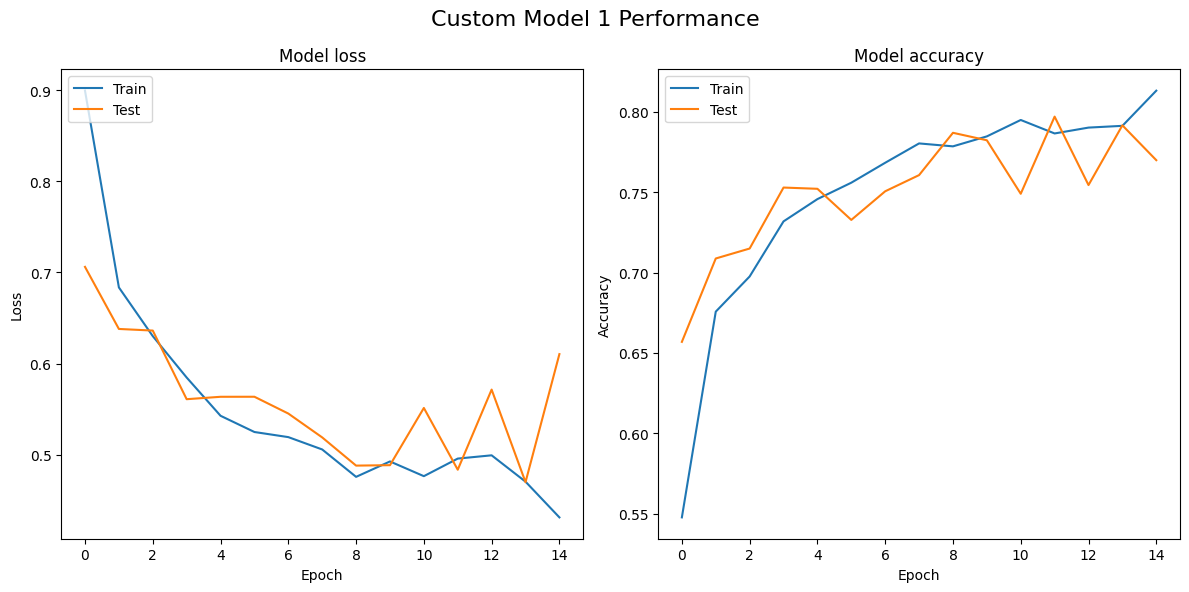

In [ ]:
plot_history(model_custom_1_history, title='Custom Model 1 Performance')

At first glance, it's clear that after epoch 8, the training loss is consistently lower than the validation loss, and in fact, the validation loss is actually increasing. This suggests that the **model is overfitting to the training data**. To address this, in the second custom model, we will implement a custom CNN model with dropout layers and regularization techniques to prevent overfitting (more on this later).

Furthermore, while the rest of the plots look reasonable enough, **initially**, an interesting observation we made was that **both our training and validation loss curves counterintiutively increased over time** (as epoch number increases). This puzzled us, but we ultimately realized that this was due to the fact that the **Adam optimizer's default learning rate of 1e-3 was too high** for our model architecture and the task at hand. To address this and have some decently satisfactory results for our first model, we decided to reduce the learning rate to 1e-4. This helped us achieve a more stable training process and better convergence, though much more tuning was needed to improve the model's performance—as we'll see in future models.

In [ ]:
# Save the model
model_custom_1.save("./models/model_custom_1.h5")

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model for inference
model_custom_1_loaded = load_model("./models/model_custom_1.h5")
print(model_custom_1_loaded.predict(X_test[:5]).argmax(axis=1))
print(y_test[:5].to_numpy().argmax(axis=1))

1/1 [==============================] - 0s 248ms/step
[2 0 1 1 1]
[2 0 1 1 0]


In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model (or any tensorflow model) to local ONNX file
def save_model_onxx(model, model_filename, framework='keras', transfer_learning=False, deep_learning=False):
    onnx_model = model_to_onnx(
        model,
        framework=framework,
        transfer_learning=transfer_learning,
        deep_learning=deep_learning
    )

    with open(model_filename, "wb") as f:
        f.write(onnx_model.SerializeToString())
        print(f"Model saved to {model_filename}")

In [ ]:
save_model_onxx(model_custom_1_loaded, "./models/model_custom_1.onnx", deep_learning=True)

In [ ]:
def upload_preds_to_aimodelshare(model, model_filename, X_test, y_test, experiment, preprocessor_filename='preprocessor.zip'):
    # Generate predictions and extract the index of the highest probability
    prediction_column_index = model.predict(X_test).argmax(axis=1)
    # Extract the text labels for the highest probability index
    prediction_labels = [y_test.columns[i] for i in prediction_column_index]
    # Submit predictions to competition Leaderboard
    experiment.submit_model(
        model=model_filename,
        preprocessor=preprocessor_filename,
        prediction_submission=prediction_labels
    )

In [ ]:
upload_preds_to_aimodelshare(
    model_custom_1_loaded,
    "./models/model_custom_1.onnx",
    X_test, y_test,
    experiment
)

### Architectural Design Choices
Using the given reference code as a starting point, we designed our CNN architecture with multiple convolutional blocks, each consisting of convolutional layers with different filter sizes and followed by max-pooling and dropout layers. The depth of the network increases gradually, with the number of filters doubling at each block (32, 64, 128, 256...). This allows the network to learn increasingly complex and abstract representations as it progresses through the layers. The use of smaller 3x3 filters after the initial 5x5 filters in each block is a common pattern that helps the network learn more complex features in a hierarchical manner. The final layers are fully connected dense layers, which combine the high-level features learned by the convolutional blocks for classification.

### Techniques to Prevent Overfitting (Regularization and Callbacks)
For the first custom model, we did not include any explicit regularization techniques like L2 regularization or dropout layers. This was intentional to observe the model's performance without any regularization and to establish a baseline for comparison. As mentioned earlier, the model exhibited signs of overfitting, which we aim to address in the subsequent models (See Custom Models 2 and 3).

### Hyperparameter Tuning
Initially, for the first iteration of our custom model, we used the default values for the learning rate (0.001) and batch size (32). However, as discussed above, we observed something peculiar in the loss curves: the loss was increasing over time, which indicated that the model had trouble converging to a local/global minima. As a result, we decided to experiment with a smaller learning rate (0.0001) to see if it would help the model converge better.

### Loss Function & Optimizer
For the loss function, we chose categorical cross-entropy, which is a standard choice for multi-class classification tasks. This loss function measures the performance of the model by comparing the predicted probabilities for each class with the true class labels, and it is well-suited for problems where the classes are mutually exclusive.

For the optimizer, we used [Adam](https://arxiv.org/pdf/1412.6980.pdf), which is a popular choice for its adaptive learning rate and good convergence properties. At a high level, Adam combines the benefits of momentum and RMSProp, adapting the learning rate for each parameter based on the gradients and their moments. This often leads to faster convergence and better performance compared to other optimizers like stochastic gradient descent (SGD).

### Overall Evaluation
As expected, this rather rudimentary model did not perform exceptionally well, with a validation accuracy of around 0.76. The model definitely overfit to the training data, as evidenced by the increasing validation loss and the gap between the training and validation accuracy. The decision to reduce the learning rate to 0.0001 helped stabilize the training process, but more sophisticated regularization techniques are needed to improve the model's generalization capabilities. As discussed above, this first custom model serves as a baseline for comparison with the subsequent models. Onwards to Custom Model 2!

## Custom Model 2

In [ ]:
# First, create a dataset of augmented images to train our models with
BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).map(lambda x, y: (image_augmentations(x), y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).map(lambda x, y: (image_augmentations(x), y))
# ^ NOTE: Akarsh mentioned in class to augment the test/validation dataset as well

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.initializers import HeNormal

# Define the input shape
input_shape = X_train[0].shape

# Define the model architecture
model_custom_2 = Sequential([
    Conv2D(kernel_size=3, filters=32, padding='same', activation='gelu', input_shape=input_shape, kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Conv2D(kernel_size=5, filters=32, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(kernel_size=3, filters=64, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Conv2D(kernel_size=5, filters=64, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(kernel_size=3, filters=128, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Conv2D(kernel_size=5, filters=128, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(kernel_size=3, filters=256, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Conv2D(kernel_size=5, filters=256, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(kernel_size=3, filters=512, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Conv2D(kernel_size=5, filters=512, padding='same', activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='gelu', kernel_regularizer=l2(0.001), kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model_custom_2.compile(
    optimizer=Adam(lr=1e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_custom_2.summary()

2024-04-02 21:21:36.103498: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-02 21:21:36.103526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-02 21:21:36.103532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-02 21:21:36.103848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 21:21:36.104195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      102464    
                                                        

In [ ]:
NUM_EPOCHS = 10

# Set up callbacks
# Learning rate scheduler: reduce the learning rate by 10% after every 5 epochs if the validation loss does not improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1e-6)

# Early stopping: stop training if the validation loss does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Fit the model
model_custom_2_history = model_custom_2.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    # steps_per_epoch=X_train.shape[0] // batch_size,  # Number of images in one epoch
    validation_data=test_dataset,
    # validation_steps=X_test.shape[0] // batch_size,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
172/172 [==============================] - 106s 584ms/step - loss: 7.3074 - accuracy: 0.3619 - val_loss: 3.3395 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - 100s 581ms/step - loss: 2.7868 - accuracy: 0.5184 - val_loss: 2.0081 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - 100s 577ms/step - loss: 2.0092 - accuracy: 0.5907 - val_loss: 1.7793 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - 104s 601ms/step - loss: 1.7568 - accuracy: 0.5987 - val_loss: 1.3642 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 5/10
172/172 [==============================] - 102s 591ms/step - loss: 1.5255 - accuracy: 0.6363 - val_loss: 2.0419 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 6/10
172/172 [==============================] - 100s 582ms/step - loss: 1.2510 - accuracy: 0.6468 - val_loss: 1.0759 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 7/10
172/172 [==========================

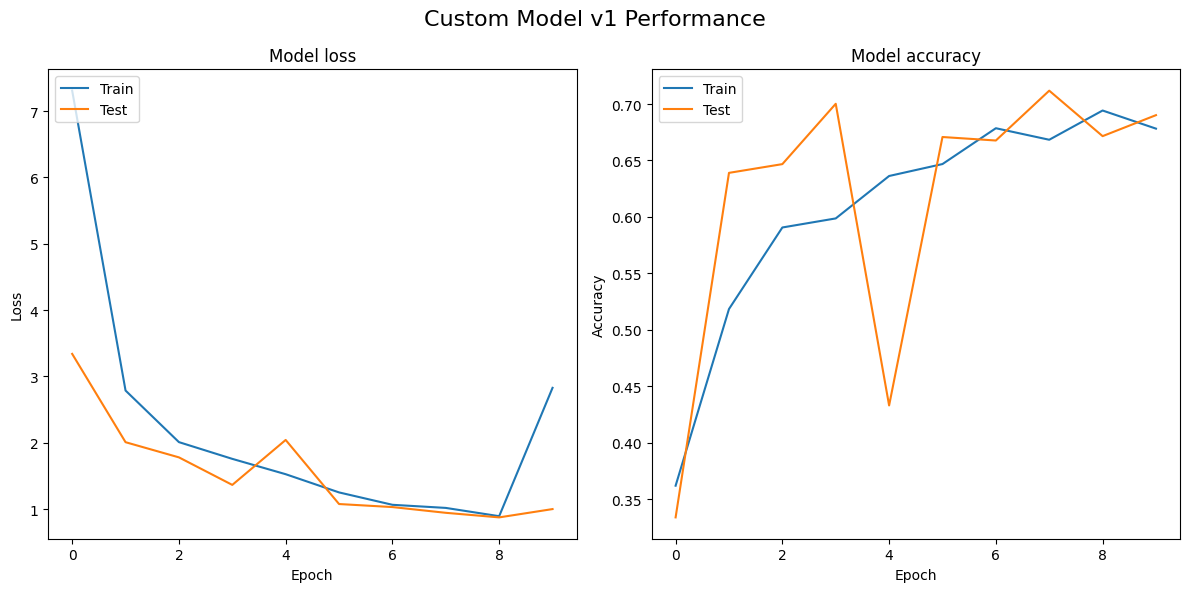

In [ ]:
plot_history(model_custom_2_history)

Interestingly enough, despite being more complex than the first custom model, the second custom model actually performed worse in terms of validation accuracy (~78% for model 1 vs. ~68% for model 2). This was a bit surprising to us, but it was a good learning experience to see that more complexity does not always equate to better performance. In this case, the model likely suffered from overfitting due to the increased number of parameters and layers, which could not be effectively regularized by the dropout layers alone.

Furthermore, another puzzling finding is that after the 8th epoch, the training loss seemingly randomly spikes upward, which is likely an indication of a potential exploding gradient problem. This could be due to the increased complexity of the model, which requires more effective mitigation than just weight initialization and dropout layers.

NOTE: The plot name above has a typo. This is NOT displaying the performance of model 1, but the performance of model 2. Apologies for the confusion.

In [ ]:
# Save the model as h5
model_custom_2.save("./models/model_custom_2.h5")

# Save the model as onnx and upload predictions to AI Model Share
save_model_onxx(model_custom_2, "./models/model_custom_2.onnx", deep_learning=True)
upload_preds_to_aimodelshare(
    model_custom_2,
    "./models/model_custom_2.onnx",
    X_test, y_test,
    experiment
)

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Architectural Design Choices
In contrast to custom model 1, this one incorporates several more sophisticated techniques and design choices. Instead of employing standard ReLU activation functions, here, we utilize the GELU (Gaussian Error Linear Unit) activation function for all convolutional and dense layers, except for the final output layer which uses softmax. GELU is a smoother, more continuous shape than ReLU and provides better performance as seen in [OpenAI's GPT models](https://proceedings.neurips.cc/paper_files/paper/2021/hash/2f3c6a4cd8af177f6456e7e51a916ff3-Abstract.html).

One challenge we ran into was an issue with **exploding gradients**, which caused the loss value to randomly spike from ~1 to the double or even triple digits. To mitigate this, we employ the He Normal (HeNormal) kernel initializer for all convolutional and dense layers, which can help stabilize the training process by initializing the weights in a way that prevents exploding gradients. Additionally, we use gradient clipping on our Adam optimizer with a norm value of 1.0 to prevent the gradients from becoming too large during training, which can lead to unstable training and convergence issues.

### Techniques to Prevent Overfitting (Regularization and Callbacks)
Whereas model 1 did not consist of any explicit regularization techniques, in the second implementation of our model, we implemented several regularization techniques and callbacks.

L2 regularization (weight decay) was applied to the kernel weights of all convolutional and dense layers. This adds a penalty term to the loss function that encourages smaller weight values, which can help prevent overfitting.

Dropout layers were also used after each convolutional block and before the final dense layers. As discussed in class, dropout randomly sets a fraction of input units to zero during training, effectively breaking co-adaptation of neurons and forcing the network to learn more robust and redundant representations.

The EarlyStopping callback was used to monitor the validation loss and stop training if it didn't improve for a certain number of epochs. We used a patience of 10 steps (i.e. if the validation loss didn't improve for 10 steps, we stop training). This prevents the model from overfitting to the training data once it has converged.

The ReduceLROnPlateau callback was also implemented to monitor the validation loss and reduce the learning rate by a factor of 0.1 if the validation loss didn't improve for a certain number of epochs (patience=5 in this case). This can help the model escape local minima and potentially achieve better performance.

### Hyperparameter Tuning
For the second custom model, we didn't alter too many hyperparameters except for the batch size—reducing that from 32 to 16. This was done to see if a smaller batch size would help the model generalize better and prevent overfitting. We also kept the learning rate at 0.0001, as it seemed to work well in the first model. The other hyperparameters were kept the same as the first model to maintain consistency and isolate the effects of the regularization techniques.

## Custom Model 3

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.initializers import LecunNormal, GlorotNormal

# Define the input shape
input_shape = X_train[0].shape

# Define the model architecture
model_custom_3 = Sequential([
   Conv2D(kernel_size=3, filters=32, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal(), input_shape=input_shape),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=32, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Conv2D(kernel_size=3, filters=64, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=64, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Conv2D(kernel_size=3, filters=128, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=128, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Conv2D(kernel_size=3, filters=256, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=256, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Conv2D(kernel_size=3, filters=512, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=512, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Conv2D(kernel_size=3, filters=1024, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   Conv2D(kernel_size=5, filters=1024, padding='same', kernel_regularizer=l2(0.001), kernel_initializer=LecunNormal()),
   BatchNormalization(),
   Activation('swish'),
   MaxPooling2D(pool_size=2),
   Dropout(0.2),

   Flatten(),

   Dense(512, kernel_regularizer=l2(0.001), kernel_initializer=GlorotNormal()),
   BatchNormalization(),
   Activation('swish'),
   Dropout(0.5),

   Dense(3, activation='softmax')
])

# Compile the model
model_custom_3.compile(
    optimizer=Adam(lr=1e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_custom_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_26 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_26 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 256, 256, 32)      25632     
                                                                 
 batch_normalization_27 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_27 (Activation)  (None, 256, 256, 32)     

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

NUM_EPOCHS = 30

# Set up callbacks
# Learning rate scheduler: reduce the learning rate by 10% after every 5 epochs if the validation loss does not improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1e-8)

# Early stopping: stop training if the validation loss does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)

# Model checkpoint: save the best model based on validation loss
model_checkpoint = ModelCheckpoint('./models/model_custom_3_best.h5', monitor='val_loss', verbose=1, save_best_only=True)

# TensorBoard: visualize training and validation metrics
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Fit the model
model_custom_3_history = model_custom_3.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint, tensorboard]
)

Epoch 1/30


2024-04-02 17:33:39.965753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


172/172 [==============================] - ETA: 0s - loss: 3.2445 - accuracy: 0.5655
Epoch 1: val_loss improved from inf to 1.87143, saving model to ./models/model_custom_3_best.h5
172/172 [==============================] - 133s 727ms/step - loss: 3.2445 - accuracy: 0.5655 - val_loss: 1.8714 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/30
172/172 [==============================] - ETA: 0s - loss: 1.5466 - accuracy: 0.6147
Epoch 2: val_loss did not improve from 1.87143
172/172 [==============================] - 120s 697ms/step - loss: 1.5466 - accuracy: 0.6147 - val_loss: 2.1516 - val_accuracy: 0.3331 - lr: 0.0010
Epoch 3/30
172/172 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.6279
Epoch 3: val_loss did not improve from 1.87143
172/172 [==============================] - 124s 717ms/step - loss: 1.4055 - accuracy: 0.6279 - val_loss: 4.0865 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 4/30
172/172 [==============================] - ETA: 0s - loss: 1.2921 - accuracy: 

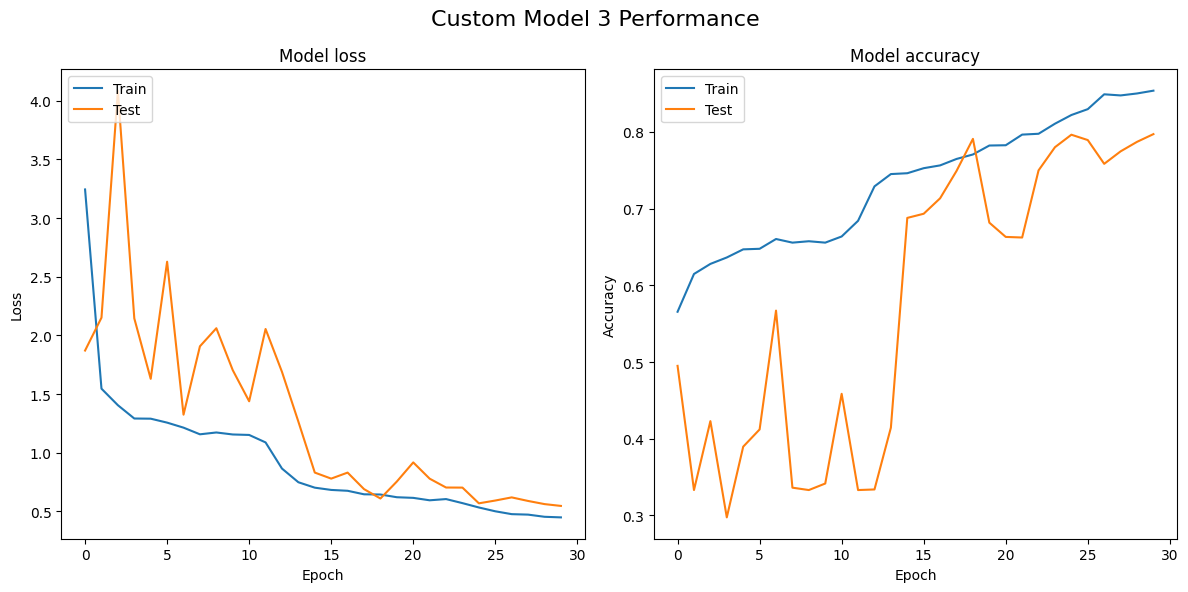

In [ ]:
plot_history(model_custom_3_history, title='Custom Model 3 Performance')

According to our loss and accuracy curves, it seems that model 3 is the best performing of our 3 custom models so far, approaching ~85% validation accuracy. This makes sense given the fact that this is the most complex model we've built yet, with a deeper architecture (12 Conv2D layers), more regularization techniques, and a more sophisticated design involving complex callbacks.

However, we do notice that overfitting is still a concern, as the training loss is consistently lower than the validation loss, and the training accuracy is higher than the validation accuracy—with the latter acting a bit erratic. This suggests that the model is likely learning the training data too well and not generalizing to unseen data. To address this, we may need to further increase the dropout rate, add more regularization, or perhaps improve our data augmentation pipeline.

In [ ]:
# Save the model as h5 (not needed since best model is saved using ModelCheckpoint)
# model_custom_3.save("./models/model_custom_2.h5")

# Load the best model
model_custom_3_best = load_model("./models/model_custom_3_best.h5")

# Save the model as onnx and upload predictions to AI Model Share
save_model_onxx(model_custom_3_best, "./models/model_custom_3_best.onnx", deep_learning=True)
upload_preds_to_aimodelshare(
    model_custom_3_best,
    "./models/model_custom_3_best.onnx",
    X_test, y_test,
    experiment,
)

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-04-02 22:10:27,522 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2024-04-02 22:10:27,525 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-04-02 22:10:31,054 - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.RestoredOptimizer` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RestoredOptimizer`.
2024-04-02 22:10:31,801 - INFO - Signatures found in model: [serving_default].
2024-04-02 22:10:31,801 - WARNING - '--signature_def' not specified, using first signature: serving_default
2024-0

Model saved to ./models/model_custom_3_best.onnx
41/41 [==============================] - 16s 360ms/step

Your model has been submitted as model version 479

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:3340


### Architectural Design Choices
Building on models 1 and 2, model 3 utilizes the Swish activation function instead of ReLU or GELU, which has been shown to perform well in various deep learning tasks, particularly in computer vision applications. The LeCun Normal kernel initializer is employed for all convolutional layers, as it is specifically designed for non-linear activation functions like Swish. For the dense layers, the Xavier Normal initializer is used, which helps maintain the scale of the gradients during backpropagation. We referenced [Hanin et al., 2018](https://arxiv.org/pdf/1803.01719.pdf) for these design choices around kernel initializers.


### Techniques to Prevent Overfitting (Regularization and Callbacks)
Notably, in this model, we also incorporate batch normalization layers after each convolutional layer and before the activation function. Batch normalization can aid in training convergence by reducing internal covariate shift and can also act as a regularizer, potentially improving the model's performance.


### Significant Challenges Encountered
In all honesty, the biggest challenge we faced was managing our developer environment(s). Since we were instructed to initially use Google Colab, we mainly developed on that platform. However, we encountered issues with the runtime limits which made it difficult to train large models without Colab giving us `Runtime disconnected` errors "due to inactivity or reaching its maximum duration." Since we also did not have Colab Pro or access to Google Cloud credits via the course, we had to switch over to running everything locally on our machines which was a bit of a hassle—especially since we all have different machines (2 Macs and 1 Windows). This required us to install all the necessary libraries and dependencies on our local machines, which took some time to get right. We also had to deal with issues related to GPU memory and runtime limits, which required us to optimize our code and data pipeline to make the most of the available resources. Overall, this experience taught us the importance of adaptability and problem-solving skills when dealing with technical challenges, as well as the need for effective resource management in machine learning projects.


. To overcome this challenge, we had to optimize our code and data pipeline to make the most of the available resources. We also had to switch to using local environments like Jupyter notebooks and Google Cloud Platform to run more computationally intensive experiments. This experience taught us the importance of adaptability and problem-solving skills when dealing with technical challenges, as well as the need for effective resource management in machine learning projects.

 to ensure that all team members had access to the same resources and libraries. This required us to coordinate our efforts and ensure that everyone was on the same page. We also had to deal with issues related to GPU memory and runtime limits, which required us to optimize our code and data pipeline to make the most of the available resources. Overall, this experience taught us the importance of effective communication and collaboration in a team setting, as well as the need for adaptability and problem-solving skills when dealing with technical challenges.

# **STEP 6(b): Transfer Learning models**

You will use a minimum of 2 Pre-trained models and Fine-tune them on our dataset. Take careful choices about which models you get from the internet. Cite their usage properly within this notebook, and in the Github repo (instructions in last section).


**Andy:** our first Transfer Learning Model will utilize VGG19

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=(192,192,3), include_top=False, weights='imagenet')
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model_vgg19 = Model(inputs=base_model.inputs, outputs=output)

# summarize
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
with tf.device('/device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_vgg19.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  #model_vgg19.fit(X_train, y_train,batch_size=1,
  #        epochs = 6, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])
  model_vgg19.fit(train_dataset,batch_size=1,
          epochs = 20, verbose=1,validation_data=(test_dataset),callbacks=[mc,red_lr])

Epoch 1/20
172/172 [==============================] - ETA: 0s - loss: 1.1876 - acc: 0.4834
Epoch 00001: val_acc improved from -inf to 0.64601, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 81s 430ms/step - loss: 1.1876 - acc: 0.4834 - val_loss: 0.8147 - val_acc: 0.6460 - lr: 0.0100
Epoch 2/20
172/172 [==============================] - ETA: 0s - loss: 0.8853 - acc: 0.5790
Epoch 00002: val_acc improved from 0.64601 to 0.72270, saving model to best_model.h5
172/172 [==============================] - 68s 396ms/step - loss: 0.8853 - acc: 0.5790 - val_loss: 0.6988 - val_acc: 0.7227 - lr: 0.0100
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: 0.7674 - acc: 0.6582
Epoch 00003: val_acc did not improve from 0.72270
172/172 [==============================] - 88s 513ms/step - loss: 0.7674 - acc: 0.6582 - val_loss: 1.4258 - val_acc: 0.4144 - lr: 0.0100
Epoch 4/20
172/172 [==============================] - ETA: 0s - loss: 0.6907 - acc: 0.7005
Epoch 00004: val_acc did not improve from 0.72270

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
172/172 [==============================] - 87s 510m

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model_vgg19.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model_vgg19.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.0025, 0.00125, 0.00125, 0.001, 0.001, 0.001, 0.001, 0.001]
19


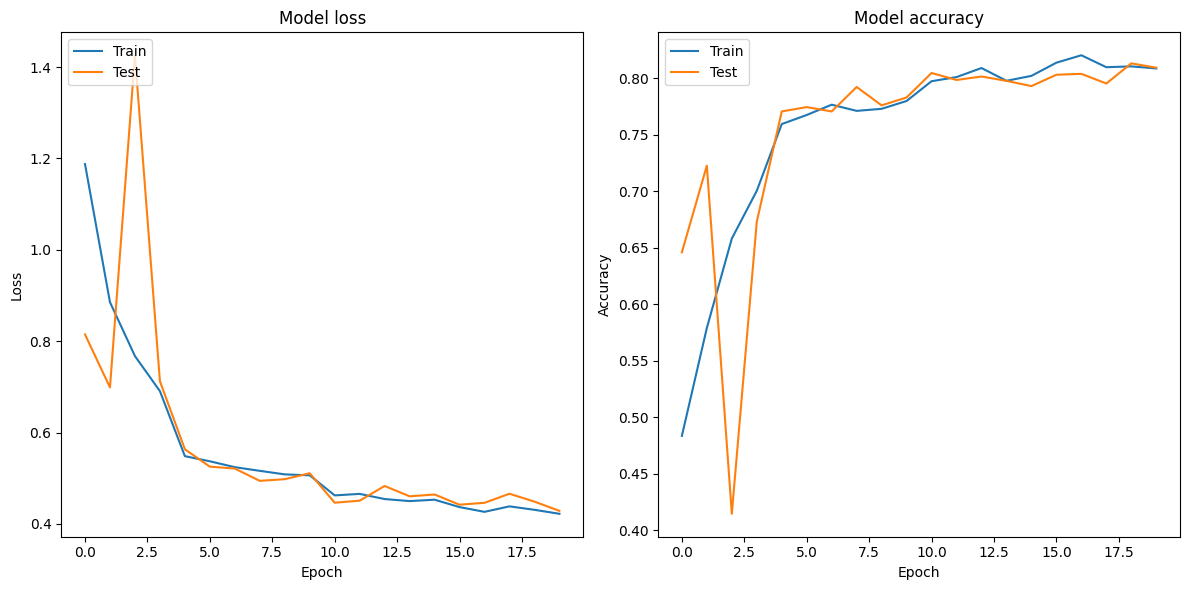

In [ ]:
# Plot training & validation loss & accuracy values

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation loss values in the first subplot
axs[0].plot(model_vgg19.history.history['loss'])
axs[0].plot(model_vgg19.history.history['val_loss'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values in the second subplot
axs[1].plot(model_vgg19.history.history['acc'])
axs[1].plot(model_vgg19.history.history['val_acc'])
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

In [ ]:
model_vgg19.save("model_vgg19.h5", save_format="h5")

**Andy:** Second Transfer Learning Model will utilize DenseNet201 (this was one of the top performers in the Chowdhury et al. paper)

In [ ]:
from tensorflow.keras.applications import DenseNet201

IMG_SHAPE = (192, 192, 3)

base_model_2 = DenseNet201(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model_2.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 198, 198, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 96, 96, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
base_model_2.trainable = False

In [ ]:
flat2 = Flatten()(base_model_2.layers[-1].output)
class2 = Dense(1024, activation='relu')(flat2)
output_2 = Dense(3, activation='softmax')(class2)
# define new model
model_dense201 = Model(inputs=base_model_2.inputs, outputs=output_2)

# summarize
model_dense201.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 198, 198, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 96, 96, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1/conv[0][0]']    

In [ ]:
with tf.device('/device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_dense201.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  model_dense201.fit(train_dataset,batch_size=1,
          epochs = 15, verbose=1,validation_data=(test_dataset),callbacks=[mc,red_lr])

Epoch 1/15
172/172 [==============================] - ETA: 0s - loss: 1.0826 - acc: 0.7439
Epoch 00001: val_acc improved from -inf to 0.82184, saving model to best_model_2.h5
172/172 [==============================] - 97s 468ms/step - loss: 1.0826 - acc: 0.7439 - val_loss: 0.4054 - val_acc: 0.8218 - lr: 0.0100
Epoch 2/15
172/172 [==============================] - ETA: 0s - loss: 0.3823 - acc: 0.8362
Epoch 00002: val_acc improved from 0.82184 to 0.84198, saving model to best_model_2.h5
172/172 [==============================] - 72s 422ms/step - loss: 0.3823 - acc: 0.8362 - val_loss: 0.3797 - val_acc: 0.8420 - lr: 0.0100
Epoch 3/15
172/172 [==============================] - ETA: 0s - loss: 0.3311 - acc: 0.8581
Epoch 00003: val_acc did not improve from 0.84198
172/172 [==============================] - 85s 496ms/step - loss: 0.3311 - acc: 0.8581 - val_loss: 0.5477 - val_acc: 0.7823 - lr: 0.0100
Epoch 4/15
172/172 [==============================] - ETA: 0s - loss: 0.3092 - acc: 0.8701
Epoc

In [ ]:
learning_rates_2=model_dense201.history.history['lr'] # learning rates at each epoch

best_model_epoch_2=np.argmax(model_dense201.history.history['val_acc'])+1 # epoch of best model

print(learning_rates_2)
print(best_model_epoch_2)

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.00125, 0.00125, 0.001]
13


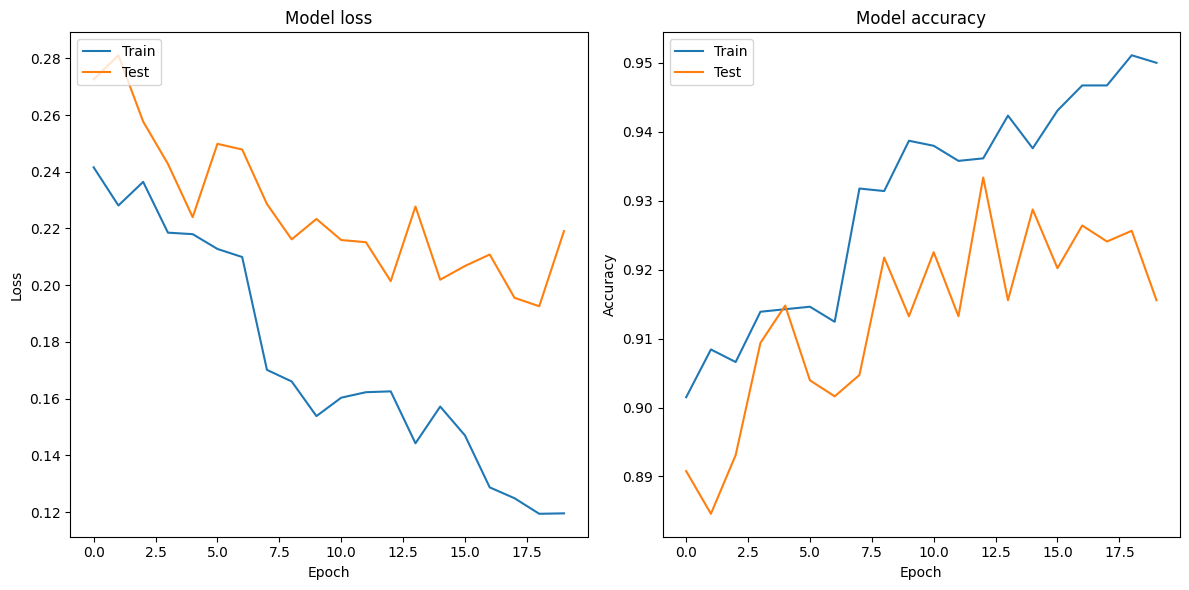

In [ ]:
# Plot training & validation loss & accuracy values

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation loss values in the first subplot
axs[0].plot(model_dense201.history.history['loss'])
axs[0].plot(model_dense201.history.history['val_loss'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values in the second subplot
axs[1].plot(model_dense201.history.history['acc'])
axs[1].plot(model_dense201.history.history['val_acc'])
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

1. Which Models did you try for Transfer Learning? What was the pre-trained model originally trained on?
2. Which models converged faster upon fine-tuning? Why do you think that happened?
3. How did you do fine-tuning on this dataset? (What layers did you add / freeze / unfreeze), How many parameters were there in total in the pretrained model you finetuned? How many trainable and untrainable?
4. How does the performance of your Transfer Learning model compare with a model trained from scratch on the same task? Discuss the advantages and potential limitations of using Transfer Learning in this context.
5. Throughout the coding process, what was the most difficult decision you had to make, and how did you arrive at your final choice?




**Andy:** our third Transfer Learning Model will utilize ResNet101.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet101

IMG_SHAPE = (192, 192, 3)

base_model_3 = ResNet101(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model_3.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 198, 198, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 96, 96, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
base_model_3.trainable = False

In [ ]:
gap3 = GlobalAveragePooling2D()(base_model_3.layers[-1].output)
output_3 = Dense(3, activation='softmax')(gap3)
# define new model
model_resnet101 = Model(inputs=base_model_3.inputs, outputs=output_3)

# summarize
model_resnet101.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 198, 198, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 96, 96, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
with tf.device('/device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model_3.h5', monitor='val_acc',mode='max', verbose=0, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=0,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_resnet101.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  model_resnet101.fit(train_dataset,batch_size=16,
          epochs = 20, verbose=1,validation_data=(test_dataset),callbacks=[mc,red_lr])

Epoch 1/20
172/172 [==============================] - ETA: 0s - loss: 1.1891 - acc: 0.3273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 79s 399ms/step - loss: 1.1891 - acc: 0.3273 - val_loss: 1.1174 - val_acc: 0.3796 - lr: 0.0100
Epoch 2/20
172/172 [==============================] - 64s 371ms/step - loss: 1.1702 - acc: 0.3415 - val_loss: 1.0895 - val_acc: 0.4291 - lr: 0.0100
Epoch 3/20
172/172 [==============================] - 61s 358ms/step - loss: 1.1558 - acc: 0.3564 - val_loss: 1.0858 - val_acc: 0.4284 - lr: 0.0100
Epoch 4/20
172/172 [==============================] - 63s 368ms/step - loss: 1.1419 - acc: 0.3699 - val_loss: 1.0890 - val_acc: 0.4407 - lr: 0.0100
Epoch 5/20
172/172 [==============================] - 61s 357ms/step - loss: 1.1314 - acc: 0.3867 - val_loss: 1.0737 - val_acc: 0.4322 - lr: 0.0100
Epoch 6/20
172/172 [==============================] - 62s 360ms/step - loss: 1.1219 - acc: 0.3980 - val_loss: 1.0642 - val_acc: 0.4307 - lr: 0.0100
Epoch 7/20
172/172 [==============================] - 63s 369ms/step - loss: 1.1206 - acc: 0.3962 - val_loss: 1.0431 - val_

In [ ]:
learning_rates_3=model_resnet101.history.history['lr'] # learning rates at each epoch

best_model_epoch_3=np.argmax(model_resnet101.history.history['val_acc'])+1 # epoch of best model

print(learning_rates_3)
print(best_model_epoch_3)

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025]
18


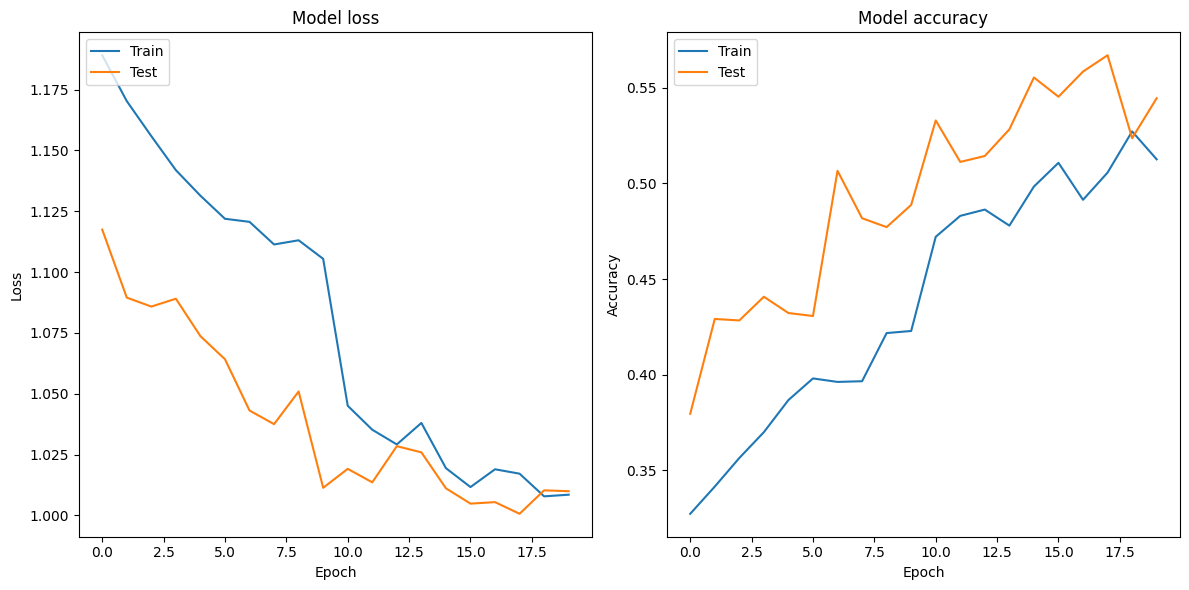

In [ ]:
# Plot training & validation loss & accuracy values

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation loss values in the first subplot
axs[0].plot(model_resnet101.history.history['loss'])
axs[0].plot(model_resnet101.history.history['val_loss'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values in the second subplot
axs[1].plot(model_resnet101.history.history['acc'])
axs[1].plot(model_resnet101.history.history['val_acc'])
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

# **STEP 7: Additional Models of your choice <span style="color:yellow;"> (10pts)</span>**

NOTE: We did not do any additional models in this section due to the fact that we already implemented extra models in Step 6a and 6b.

# **STEP 8: Analysis of your models (15 pts)**

Please see the writeups underneath each performance chart for each respective model providing an analysis of the performance. Please also refer to the GitHub readme for more detailed analyses.

# **STEP 9: Conclusions**

In conclusion, this project aimed to develop accurate deep learning models capable of detecting COVID-19 from chest X-ray images. Through an extensive iterative process, we designed and evaluated three custom convolutional neural network (CNN) models, each incorporating progressively advanced techniques and architectural choices. The first custom model served as a baseline, employing a relatively straightforward CNN architecture without explicit regularization methods. While this model achieved a reasonable validation accuracy of around 78%, it suffered from overfitting, as evidenced by the significant gap between training and validation losses/accuracies.

To address the overfitting issue, the second custom model introduced several regularization techniques, including L2 regularization, dropout layers, and early stopping. Additionally, we experimented with different activation functions (GELU), kernel initializers (He Normal), and gradient clipping to stabilize the training process. Surprisingly, despite these enhancements, the second model's performance deteriorated, achieving only around 68% validation accuracy. This counterintuitive result highlighted the complexities involved in model design and the potential pitfalls of increased complexity without effective regularization.

Building upon the lessons learned, the third custom model incorporated a more sophisticated architecture, utilizing the Swish activation function, batch normalization, and specialized kernel initializers (LeCun Normal and Xavier Normal). This model also employed advanced callbacks, such as ReduceLROnPlateau, to adaptively adjust the learning rate during training. Consequently, Model 3 emerged as the best performer, achieving a validation accuracy of around 85%. However, overfitting remained a persistent challenge, as evidenced by the consistent gap between training and validation losses/accuracies, suggesting the need for further refinements in regularization techniques, data augmentation strategies, or ensemble methods.

# **STEP 10: Github Repo <span style="color:yellow;"> (15pts)</span>**

See first cell at the top.